In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from tqdm import tqdm

from utils.config import Config
from models.base import ImageCaptioningModel
from models.attention_model import ImageCaptioningWithAttention
from inference.evaluation import post_process_caption, evaluate_captions

from data.data_set import DataSet
from text.tokenizer import Tokenizer
from pathlib import Path
import cv2


/Users/danialmoafi/UNI/projects/image_captioning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
RUN_ID = 14

In [54]:
# laod the prediction results
path_run = f"../models/checkpoints/run_{RUN_ID}"
predictions = pd.read_csv(f"{path_run}/results.csv")
predictions.sort_values(by="BLEU Score", ascending=False, inplace=True)

# select best prediction for each image
best_predictions = predictions.loc[predictions.groupby('Image Name')['BLEU Score'].idxmax()]
best_predictions.sort_values(by="BLEU Score", ascending=False, inplace=True)


MODEL_PATH = Path(f"../models/checkpoints/run_{RUN_ID}")

config = Config(experiment_id=RUN_ID)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = ImageCaptioningWithAttention(config.embed_size, config.attention_dim, config.decoder_dim, config.vocab_size, config.encoder_dim).to(device)
model.load_state_dict(torch.load(f"{MODEL_PATH}/best_model.pth", map_location=device, weights_only=True))


<All keys matched successfully>

In [80]:
# show image with true caption and predicted caption 
def show_image(image_name):
    path = "../data/raw/images/"
    true_caption = best_predictions.loc[best_predictions['Image Name'] == image_name, 'True Caption'].values[0]
    predicted_caption = best_predictions.loc[best_predictions['Image Name'] == image_name, 'Predicted Caption'].values[0]
    bleu_score = best_predictions.loc[best_predictions['Image Name'] == image_name, 'BLEU Score'].values[0]
    plt.figure(figsize=(10, 8))
    plt.imshow(Image.open(f"{path}/{image_name}"))
    plt.title(f"True Caption: {true_caption.replace('  ', '')}",fontsize=12, pad=10, wrap=True)
    plt.axis('off')
    plt.show()

            
def generate_caption_with_attention(model, image, tokenizer, temperature=0.8):
    device = 'mps'
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))
        caption = [tokenizer.word_to_idx['<start>']]
        attention_maps = []  
    
        h, w = image.shape[-2:] 
        generated_words = [] 
        
        for _ in range(config.max_length):
            inputs = torch.tensor([caption]).to(device)
            outputs = model.decoder(features, inputs)
            
            alpha = model.decoder.attention_weights[-1]  # Get last attention weight
            alpha = alpha.reshape(int(np.sqrt(alpha.shape[0])), int(np.sqrt(alpha.shape[0])))
            attention_maps.append(alpha)
            
            #temperature = 0.8
            probs = torch.softmax(outputs[:, -1, :] / temperature, dim=-1)
            word = torch.multinomial(probs, 1).item()
            word_str = tokenizer.idx_to_word[word]
            generated_words.append(word_str)
            
            caption.append(word)
            if word == tokenizer.word_to_idx['<end>']:
                break
                
        return caption, attention_maps, generated_words

def visualize_attention(image, attention_maps, generated_words):

    img = image.permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
    
    n_words = len(generated_words)
    plt.figure(figsize=(20, 4))
    
    for idx in range(n_words):
        if generated_words[idx] in ['<start>', '<end>', '<pad>']:
            continue
            
        plt.subplot(1, n_words, idx + 1)
        plt.imshow(img)
        
        # Resize attention map to match image size
        attention_map = attention_maps[idx]
        attention_map = cv2.resize(attention_map, (img.shape[1], img.shape[0]))
        plt.imshow(attention_map, alpha=0.6, cmap='hot')
        
        plt.axis('off')
        plt.title(generated_words[idx])
    
    plt.tight_layout()
    plt.show()

In [70]:
best_predictions.reset_index(drop=True, inplace=True)

2565685680_c30972455d.jpg
5    a black dog swims in wave of water .
Name: Predicted Caption, dtype: object


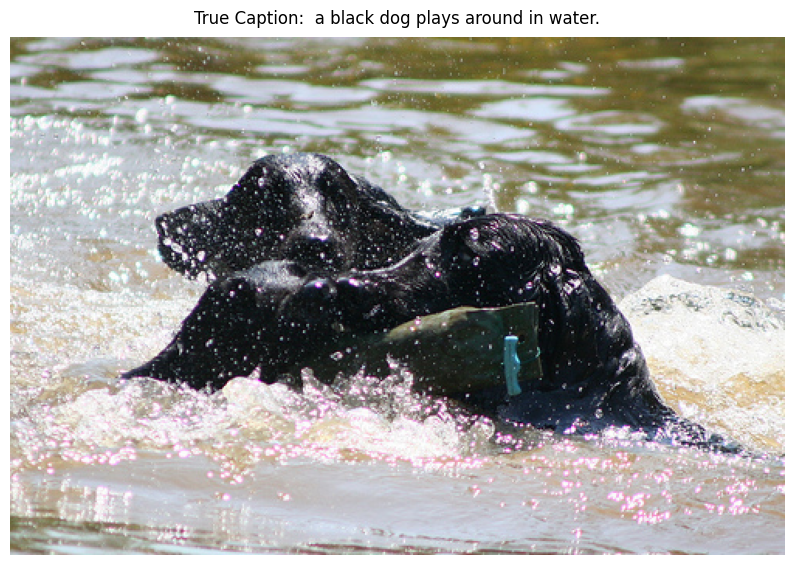

temperature:  0.1 generated_words:  ['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'water', '<end>']
temperature:  0.2 generated_words:  ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'playing', 'in', 'a', 'red', '<end>']
temperature:  0.3 generated_words:  ['a', 'man', 'is', 'walking', 'on', 'a', 'white', 'and', 'white', 'dog', '<end>']
temperature:  0.4 generated_words:  ['a', 'group', 'of', 'people', 'are', 'running', 'in', 'a', 'blue', '<end>']
temperature:  0.5 generated_words:  ['a', 'young', 'man', 'is', 'standing', 'on', 'a', 'rock', '<end>']
temperature:  0.6 generated_words:  ['two', 'boys', 'are', 'in', 'the', 'pink', 'is', 'running', 'in', 'a', 'its', '<end>']
temperature:  0.7 generated_words:  ['two', 'children', 'are', 'running', 'jumping', 'in', 'his', 'mouth', '<end>']
temperature:  0.8 generated_words:  ['a', 'young', 'girl', 'dressed', 'is', 'from', 'on', 'a', 'stick', '<end>']
temperature:  0.9 gener

In [96]:
index = 5
image_name = best_predictions['Image Name'].iloc[index] #3356369156_074750c6cc.jpg , 2699733386_c346c87ea6.jpg

print(image_name)
print(best_predictions.loc[best_predictions['Image Name'] == image_name]['Predicted Caption'])

show_image(image_name)


tokenizer = Tokenizer()
tokenizer.load_dicts(f"../{config.path}/dicts.pkl")
transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
        ])
path = "../data/raw/images/"
image = Image.open(f"{path}/{image_name}")
image = transform(image)

for temp in range(1, 12):
        caption, alphas, generated_words = generate_caption_with_attention(model, image, tokenizer, temperature=temp/10)
        print('temperature: ', temp/10, 'generated_words: ', generated_words)
        #visualize_attention(image, alphas, generated_words)

In [ ]:
# show the results for the best prediction
# After cleaning and grouping by image name, the best prediction is the one with the highest BLEU score
best_predictions.describe()


print('Best 5 predictions:')
for i in range(5):
    print('True Caption: ', best_predictions['True Caption'].iloc[i])
    print('Predicted Caption: ', best_predictions['Predicted Caption'].iloc[i])
    print('BLEU Score: ', best_predictions['BLEU Score'].iloc[i])
    print('-'*100)
    
print('Worst 5 predictions:')
for i in range(5):
    print('True Caption: ', best_predictions['True Caption'].iloc[-i])
    print('Predicted Caption: ', best_predictions['Predicted Caption'].iloc[-i])
    print('BLEU Score: ', best_predictions['BLEU Score'].iloc[-i])
    print('-'*100)


In [ ]:
# show the histogram of the bleu score 
plt.figure(figsize=(10, 8))
plt.title('BLEU Score Distribution')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.hist(best_predictions['BLEU Score'], bins=10)
plt.show()